# Notebook for experiments on modelling the second IML project data

As we go it may be good to keep this place tidy by implementing some of the suggestions made here: https://www.thoughtworks.com/insights/blog/coding-habits-data-scientist 

## TODO
* Modelling
* Tidy up code to make sure it runs in parallel where possible
* Conform to guidelines provided in link above

## 1. Dependency management
Install the provided environment.yml file in the root directory of the repository. 
If this fails, run the commands below in a terminal window. This may lead to clashes with other packages!

In [1]:
# !conda install -c conda-forge jupyterlab -y
# !conda install -c conda-forge imbalanced-learn -y
# !conda install -c conda-forge pandas-profiling -y
# !conda install -c conda-forge bokeh -y

In [2]:
!pip install pip install thundersvm

ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install


## 2. Data Visualization & Analysis 

In [3]:
import pandas_profiling
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from ipywidgets import widgets
from pandas_profiling import ProfileReport
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.svm import LinearSVC,SVC

from sklearn.model_selection import GridSearchCV
from random import sample

%matplotlib inline

In [4]:
# Load data
df_train = pd.read_csv("data/train_features.csv")
df_train_label = pd.read_csv("data/train_labels.csv")
df_test = pd.read_csv("data/test_features.csv")

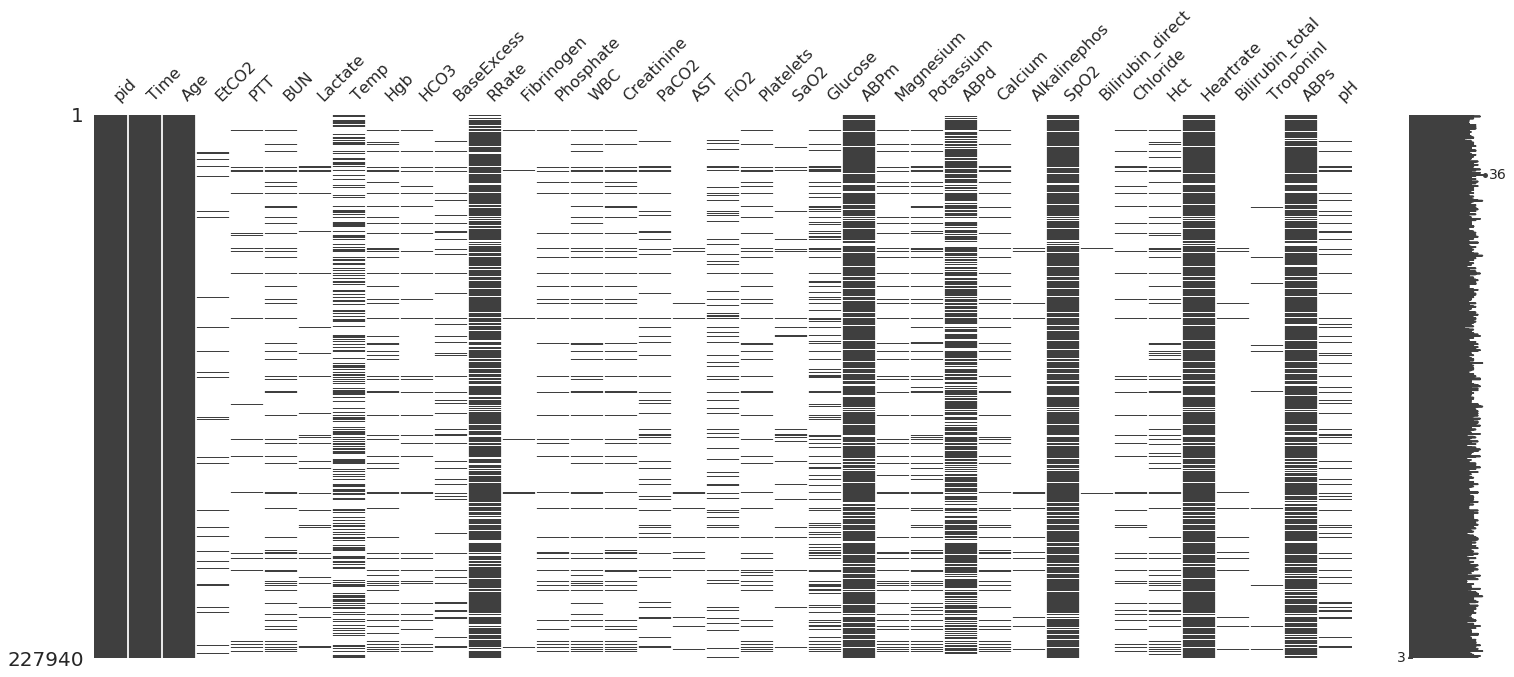

In [5]:
msno.matrix(df_train)

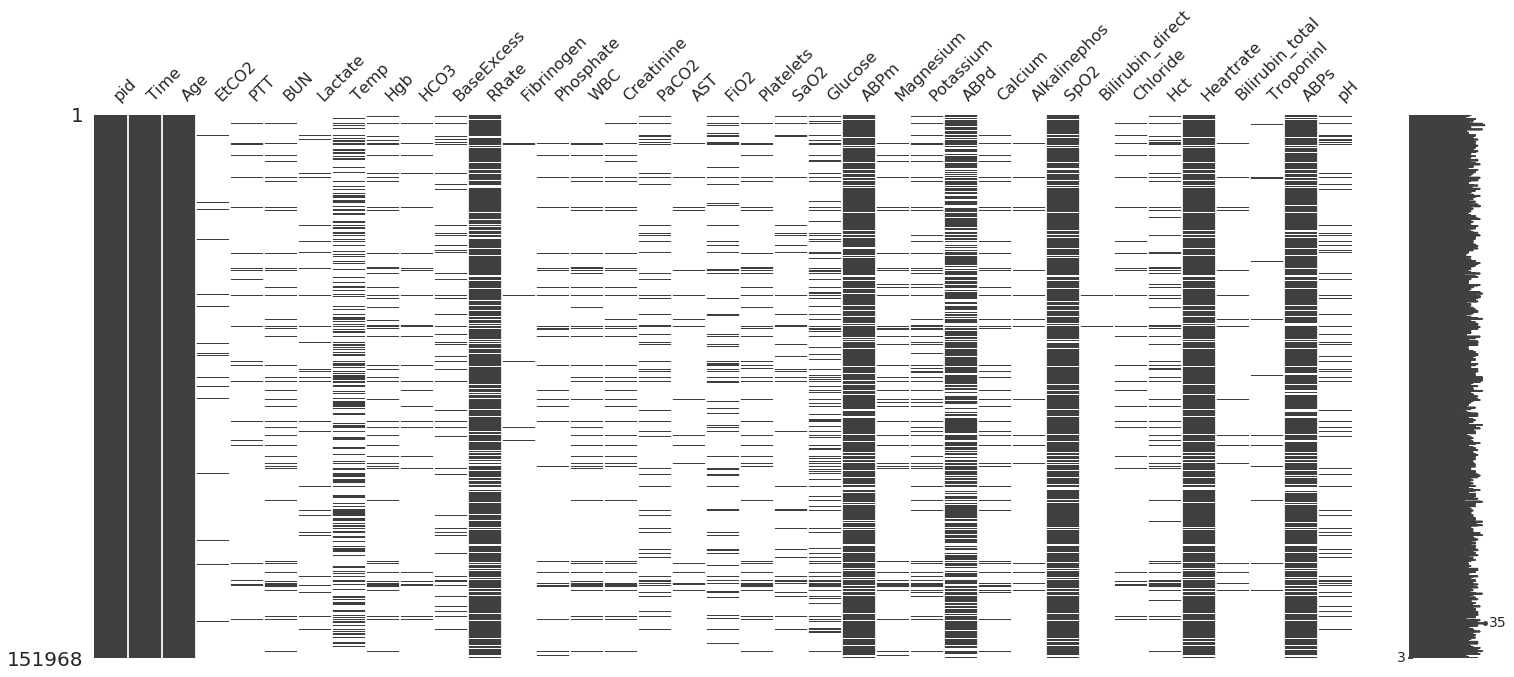

In [6]:
msno.matrix(df_test)

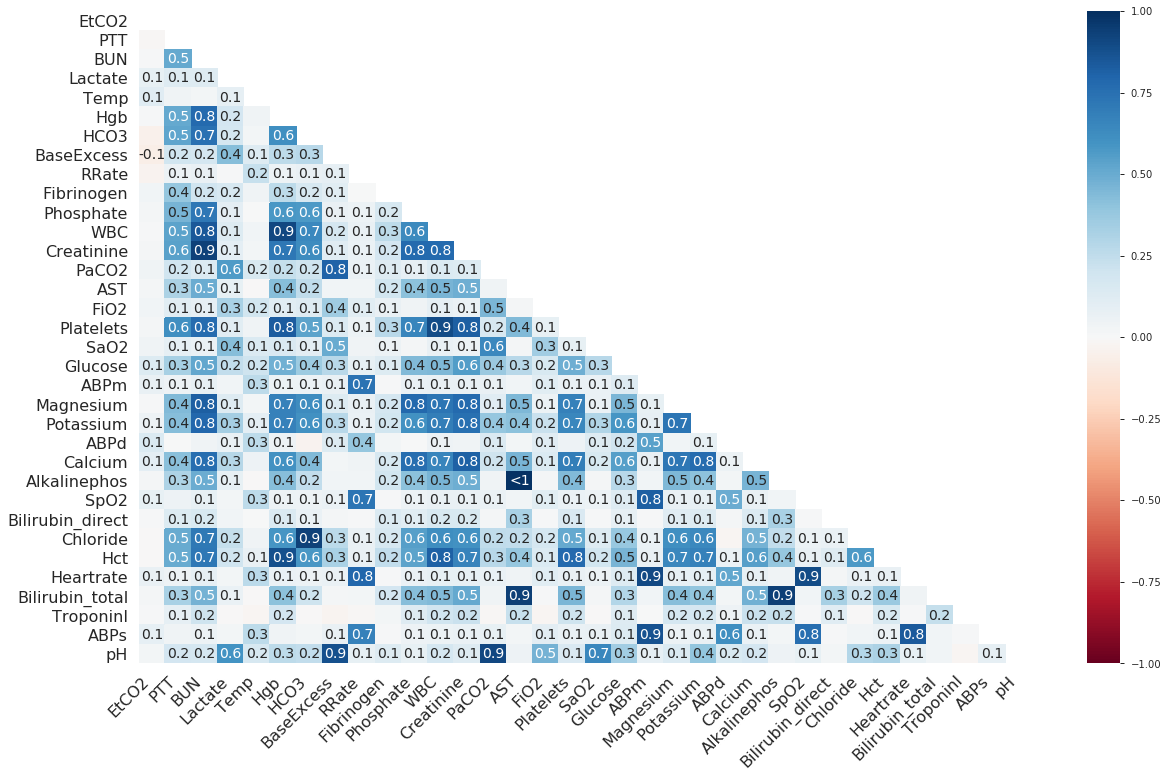

In [7]:
# The heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.
msno.heatmap(df_train)

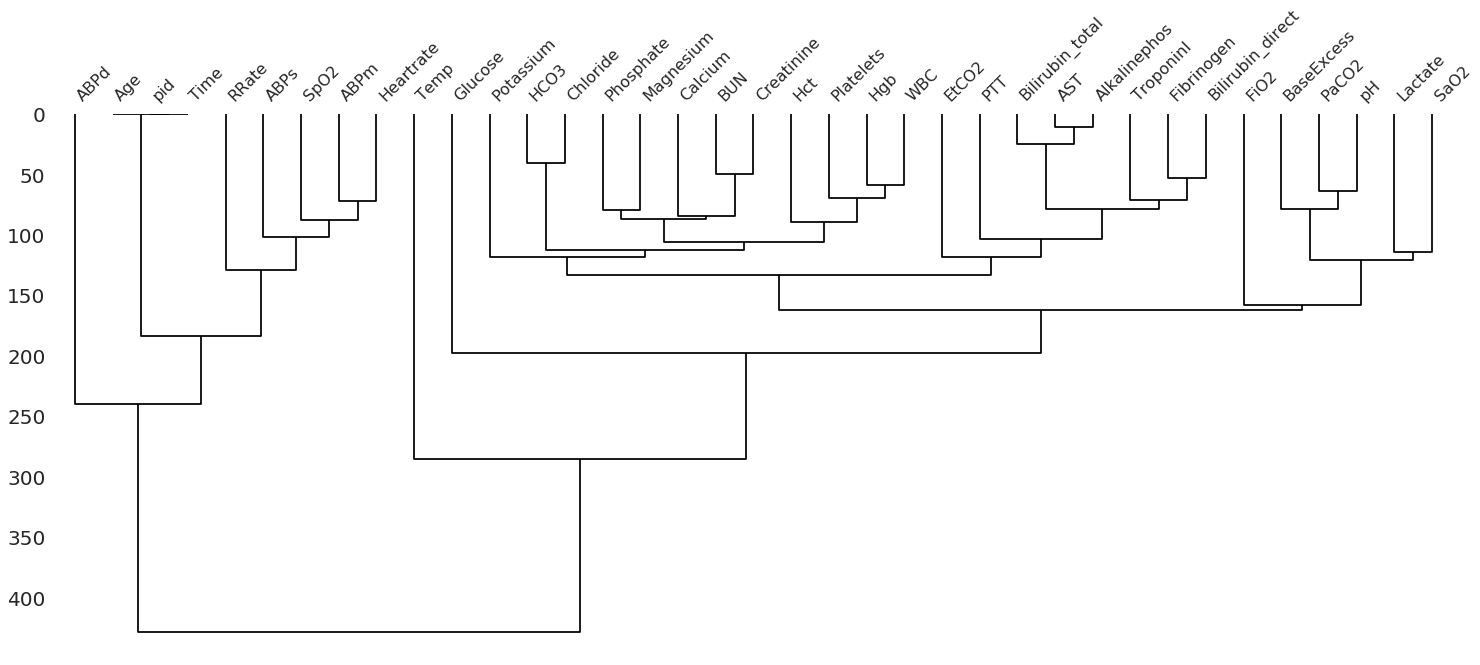

In [8]:
# Using hierarchichal clustering we can see how the nullity of a variable relates to that of another.
msno.dendrogram(df_train)

Conclusions from above plots:
* Data appears to be i.i.d.
* Some columns appear to have many more measurements than others. 
* When a column is null, other columns also tend to be null (some timepoints
seem to contain more data than others, might be useful when doing imputation)

Let's have a look at the different types and other aspects of the dataframe:


In [9]:
df_train.head(20)

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,...,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,...,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,4,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33
2,1,5,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,92.0,NaN,NaN,110.0,7.37
3,1,6,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,104.0,7.37
4,1,7,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,100.0,NaN,NaN,22.4,81.0,NaN,NaN,100.0,7.41
5,1,8,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,...,NaN,100.0,NaN,NaN,22.4,82.0,NaN,NaN,106.0,NaN
6,1,9,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,67.0,NaN,NaN,112.0,NaN
7,1,10,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,62.0,NaN,NaN,121.0,NaN
8,1,11,34.0,NaN,NaN,12.0,NaN,NaN,8.5,26.0,...,NaN,100.0,NaN,111.0,23.8,58.0,NaN,NaN,118.0,NaN
9,1,12,34.0,NaN,NaN,12.0,NaN,38.0,8.5,26.0,...,NaN,100.0,NaN,111.0,23.8,66.0,NaN,NaN,110.0,7.39


In [10]:
df_train.dtypes

pid                   int64
Time                  int64
Age                 float64
EtCO2               float64
PTT                 float64
BUN                 float64
Lactate             float64
Temp                float64
Hgb                 float64
HCO3                float64
BaseExcess          float64
RRate               float64
Fibrinogen          float64
Phosphate           float64
WBC                 float64
Creatinine          float64
PaCO2               float64
AST                 float64
FiO2                float64
Platelets           float64
SaO2                float64
Glucose             float64
ABPm                float64
Magnesium           float64
Potassium           float64
ABPd                float64
Calcium             float64
Alkalinephos        float64
SpO2                float64
Bilirubin_direct    float64
Chloride            float64
Hct                 float64
Heartrate           float64
Bilirubin_total     float64
TroponinI           float64
ABPs                

In [11]:

df_train.describe()

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,...,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
count,227940.000000,227940.000000,227940.000000,9783.000000,10299.000000,20105.000000,10756.000000,81115.000000,22295.000000,12559.00000,...,5708.000000,195192.000000,719.000000,13917.000000,27297.000000,200128.000000,5326.000000,3776.000000,191650.000000,25046.000000
mean,15788.831219,7.014399,62.073809,32.883114,40.091310,23.192664,2.859716,36.852136,10.628208,23.48810,...,97.796163,97.663449,1.390723,106.260185,31.283090,84.522371,1.640941,7.269240,122.369877,7.367231
std,9151.896286,4.716103,16.451854,7.802065,26.034961,20.024289,2.428368,0.875152,2.074859,4.40378,...,122.773379,2.786186,2.792722,5.916082,5.770425,17.643437,3.244145,25.172442,23.273834,0.074384
min,1.000000,1.000000,15.000000,10.000000,12.500000,1.000000,0.200000,21.000000,3.300000,0.00000,...,12.000000,20.000000,0.010000,66.000000,9.400000,23.000000,0.100000,0.010000,21.000000,6.820000
25%,7879.000000,4.000000,52.000000,28.500000,27.800000,12.000000,1.400000,36.000000,9.200000,21.00000,...,53.000000,96.000000,0.100000,103.000000,27.300000,72.000000,0.500000,0.030000,105.000000,7.330000
50%,15726.000000,7.000000,64.000000,33.000000,32.200000,17.000000,2.100000,37.000000,10.500000,23.90000,...,72.000000,98.000000,0.300000,107.000000,30.900000,83.000000,0.800000,0.150000,119.000000,7.370000
75%,23725.000000,10.000000,74.000000,38.000000,40.600000,27.000000,3.400000,37.000000,12.000000,26.00000,...,104.000000,100.000000,1.210000,110.000000,35.000000,95.000000,1.400000,2.050000,137.000000,7.410000
max,31658.000000,315.000000,100.000000,100.000000,250.000000,268.000000,31.000000,42.000000,23.800000,50.00000,...,3833.000000,100.000000,21.200000,141.000000,63.400000,191.000000,46.500000,440.000000,287.000000,7.780000


In [12]:
# Preliminary data analysis to see what we're dealing with here
# Expensive computation, output already on repository in separate HTML file
# profile_df_train = ProfileReport(df_train, title='Pandas Profiling Report of Training Features', html={'style':{'full_width':True}})
# profile_df_train.to_file(output_file="profile_report_training_features.html")

In [13]:
plt.rcParams['figure.figsize'] = 30, 15

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f685ef7bf50>,
      dtype=object)

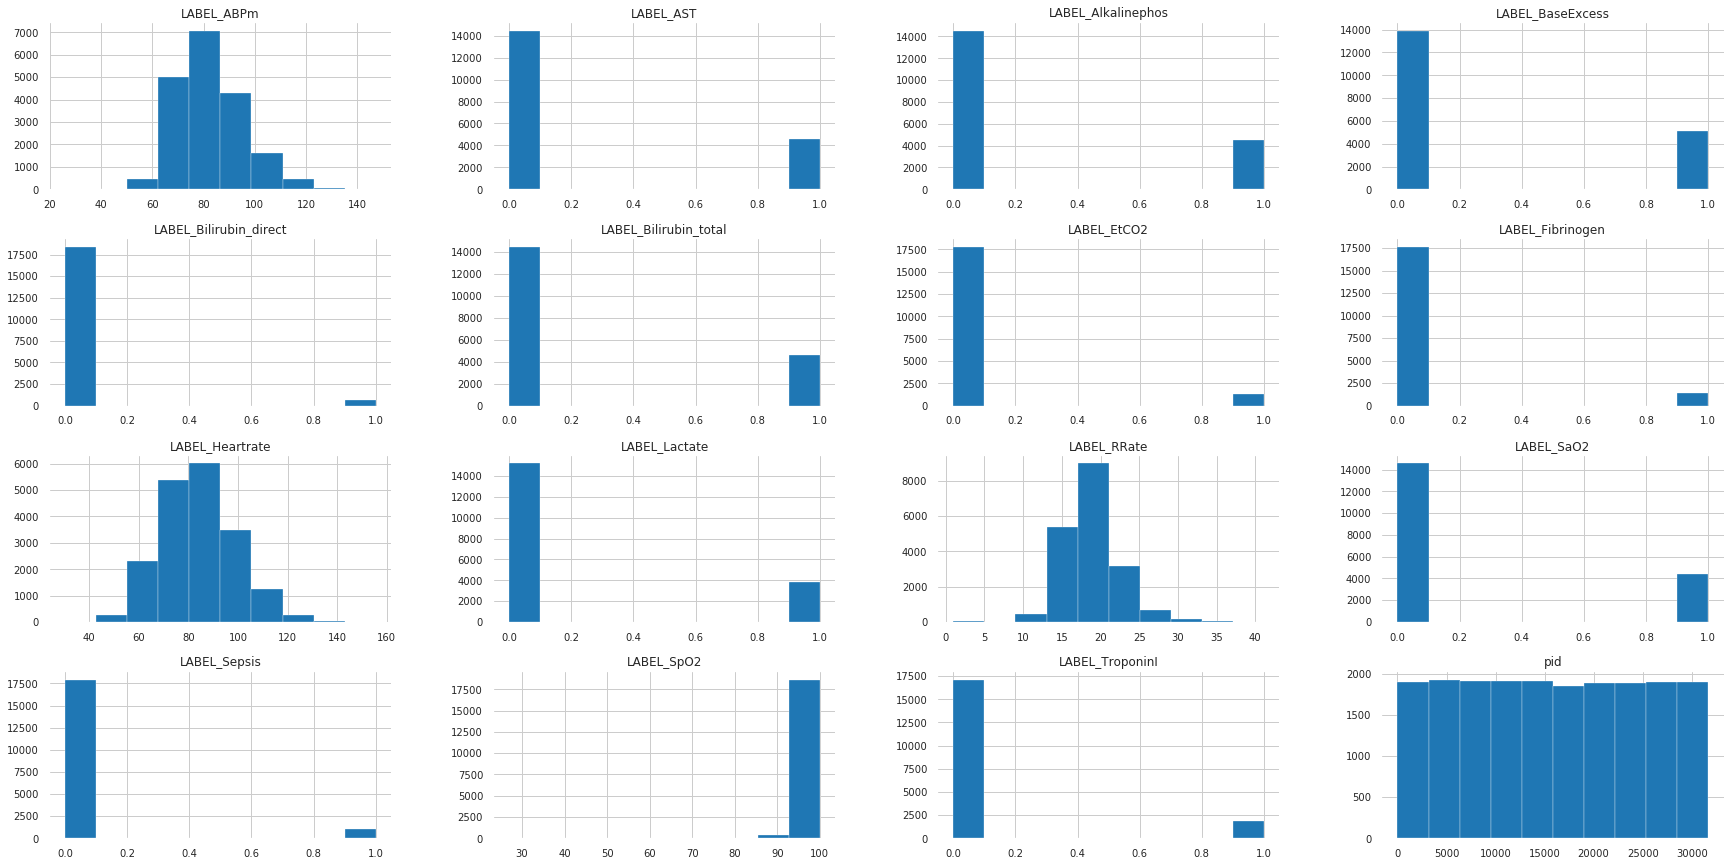

In [14]:
df_train_label.hist()

## 3. Preprocessing
### Ideas for preprocessing
Resolve class imbalance:
* Use oversampling via SMOTE and ADASYN (https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167)

Resolve missing data:
* Use averaging methods
* Use dynamic time warping and treat data as time series to get time series of equal lengths.
* Use EM algorithm
* Use algorithms that can deal with missing data

In [15]:
# list of medical tests that we will have to predict, as well as vital signs (to delete for this task)
medical_tests = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2"]
vital_signs = ["LABEL_RRate","LABEL_ABPm","LABEL_SpO2","LABEL_Heartrate"]
sepsis = ["LABEL_Sepsis"]

In [16]:
# slower version - supports patient specific mean
def fill_na_with_average_patient_column(df_train):
    columns = list(df_train.columns)
    del columns[0:2]

    df_train_preprocessed = df_train

    for i,column in enumerate(columns):
        print("{} column of {} columns processed".format(i+1,len(columns)), end="\r") 
        # Fill na with patient average 
        df_train_preprocessed[[column]] = df_train_preprocessed.groupby(['pid'])[column]\
        .transform(lambda x: x.fillna(x.mean()))
        
    # Fill na with overall column average for lack of a better option for now
    df.fillna(df.mean())
    return df_train_preprocessed

In [17]:
# quick version - does not support patient average
def fill_na_with_average_patient_column(df):
    return df.fillna(df.mean())

In [18]:
# Would be useful to distribute/multithread this part
df_train_preprocessed = fill_na_with_average_patient_column(df_train)

In [19]:
# preprocess testing data
df_test_preprocessed = fill_na_with_average_patient_column(df_test)

In [20]:
# # There are a lot less missing values now.
# msno.bar(df_train_preprocessed)
# plt.show()

In [21]:
# transform training labels for these tasks
df_train_label[medical_tests+vital_signs+sepsis] = df_train_label[medical_tests+vital_signs+sepsis].astype(int)
df_train_label_med = df_train_label.drop(columns=vital_signs+sepsis)
df_train_label_sepsis = df_train_label.drop(columns=vital_signs+medical_tests)

In [22]:
# Merging pids to make sure they map correctly.
df_train_preprocessed_merged = pd.merge(df_train_preprocessed, df_train_label,  how='left', left_on='pid', right_on ='pid')

In [23]:
# Transform to arrays for further processing
X_train = df_train_preprocessed_merged.drop(columns=medical_tests+sepsis+vital_signs).values

# get a different label for each medical test
y_train_set_med = []
for test in medical_tests:
    y_train_set_med.append(df_train_preprocessed_merged[test].values)
y_train_sepsis = df_train_preprocessed_merged['LABEL_Sepsis'].values

Resampling dataset prior to model fitting

In [24]:
def oversampling_strategies(X_train, y_train, strategy="adasyn"):
    # Oversampling methods
    if strategy=="adasyn":
        sampling_method = ADASYN()
    if strategy=="smote":
        sampling_method = SMOTE()
    
    # Undersampling methods
    if strategy=="clustercentroids":
        sampling_method = ClusterCentroids(random_state=42)
    if strategy=="random":
        sampling_method = RandomUnderSampler(random_state=0, replacement=True)
        
    X_train_resampled, y_train_resampled = sampling_method.fit_sample(X_train, y_train)
    
    print(sorted(Counter(y_train_resampled).items()))
    
    return X_train_resampled, y_train_resampled

In [25]:
# very long to compute
# compute resampled data for all medical tests 
X_train_resampled_set_med,y_train_resampled_set_med = [0]*len(y_train_set_med),[0]*len(y_train_set_med)
for i in range(len(y_train_set_med)):
    X_train_resampled_set_med[i], y_train_resampled_set_med[i] = oversampling_strategies(X_train, y_train_set_med[i], strategy="adasyn")

[(0, 166788), (1, 163166)]
[(0, 211140), (1, 210799)]
[(0, 173292), (1, 169946)]
[(0, 174096), (1, 168171)]
[(0, 173100), (1, 170289)]
[(0, 182304), (1, 181568)]
[(0, 205200), (1, 204616)]
[(0, 174672), (1, 170925)]
[(0, 220212), (1, 219496)]
[(0, 212892), (1, 212168)]


In [26]:
X_train_resampled_sepsis, y_train_resampled_sepsis = oversampling_strategies(X_train, y_train_sepsis, strategy="adasyn")

[(0, 214884), (1, 215094)]


## 4. Modelling

For now, use of Linear SVM, scales better to large datasets 

TODO: Try using regular SVR to be able to use kernels

In [27]:
# Linear
# regularization parameter
alphas = np.linspace(0.1,10,num=3)
# to perform either l1 or l2 regularization 
penalty = ["l1","l2"]

# for non linear
# kernel type
kernels = ["linear", "poly", "rbf", "sigmoid"]
# degree for poly kernel
degrees = range(1,5)
# gamma parameter for poly or rbf kernel
gamma_rbf = np.linspace(0.1,10,num=10)


Random sampling of dataset for model testing

In [28]:
def get_random_sample(X_train_resampled_set,y_train_resampled_set,size=100):
    """Sample at random datapoints from the resampled datasets for each medical test
    
    Parameters: 
        X_train_resampled_set = np.array, set of size # of medical tests, with X_train for each
        y_train_resampled_set = np.array, set of size # of medical tests, with y_train for each
                                size = int, size of selected sample
    Returns:
        X_train_rd_set,y_train_rd_set : np.array, reduced sample sets where xxx_train_rd_set[i] is the reduced
                                            set for medical test i
    """
    X_train_rd_set,y_train_rd_set = [],[]
    for i,test in enumerate(medical_tests):
        ind = sample(range(len(X_train_resampled_set[i])),size)
        X_train_rd_set.append(X_train_resampled_set[i][ind])
        y_train_rd_set.append(y_train_resampled_set[i][ind])
    return np.array(X_train_rd_set),np.array(y_train_rd_set)

In [29]:
def get_models_medical_tests(X_train_resampled_set,y_train_resampled_set, alpha=10, param_grid={"C": [1,10]}, typ="naïve", reduced=True, size=100):
    """Function to obtain models for every set of medical test, either naïve or using CV Gridsearch
    
        Parameters: X_train_resampled_set = np.array, set of size # of medical tests, with X_train for each
                    y_train_resampled_set = np.array, set of size # of medical tests, with y_train for each
                    alpha = float (for naïve) regularization parameter, ignored if typ is not naive
                    param_grid = dict (for gridsearch), dictionary of parameters to search over, ignored if typ is not gridsearch
                    typ = str in ["naïve","gridsearch","naive_non_lin","gridsearch_non_lin"], default "naïve", how the task is performed
                    reduced = boolean, default True, if random sampling of dataset to test of smaller dataset
                    size = int, size of selected sample, ignored if reduced == False
        Returns:
                svr_models = list of Linear SVR models for each medical test, where svr_models[i] is the fitted 
                            model (best estimator in the case of gridsearch) for medical_test[i]
    """
    assert typ in ["naive","gridsearch","naive_non_lin","gridsearch_non_lin"], "typ must be in ['naive','gridsearch','naive_non_lin','gridsearch_non_lin']"
    if reduced:
        X_train_resampled_set, y_train_resampled_set = get_random_sample(X_train_resampled_set,y_train_resampled_set,size=size)
    svm_models = []
    for i,test in enumerate(medical_tests):
        print("Starting iteration for test {}".format(test))
        if typ=="naive":
            # setting dual to false because n_samples>n_features
            lin_svm = LinearSVC(C=alpha,dual=False)
            lin_svm.fit(X_train_resampled_set[i],y_train_resampled_set[i])
            svm_models.append(lin_svm)
        elif typ=="gridsearch":
            cores=multiprocessing.cpu_count()-2
            gs_svm = GridSearchCV(estimator=LinearSVC(dual=False),param_grid=param_grid,n_jobs=cores,scoring="roc_auc",verbose=2)
            gs_svm.fit(X_train_resampled_set[i],y_train_resampled_set[i])
            print("The estimated auc roc score for this estimator is {}, with alpha = {}".format(gs_svm.best_score_,gs_svm.best_params_))
            svm_models.append(gs_svm.best_estimator_)
        elif typ=="naive_non_lin":
            lin_svm = SVC(C=alpha)
            lin_svm.fit(X_train_resampled_set[i],y_train_resampled_set[i])
            svm_models.append(lin_svm)
        elif typ=="gridsearch_non_lin":
            cores=multiprocessing.cpu_count()-2
            gs_svm = GridSearchCV(estimator=SVC(),param_grid=param_grid,n_jobs=cores,scoring="roc_auc",verbose=2)
            gs_svm.fit(X_train_resampled_set[i],y_train_resampled_set[i])
            print("The estimated auc roc score for this estimator is {}, with alpha = {}".format(gs_svm.best_score_,gs_svm.best_params_))
            svm_models.append(gs_svm.best_estimator_)
    return svm_models

In [30]:
def get_model_sepsis(X_train_resampled,y_train_resampled, alpha=10, param_grid={"C": [1,10]}, typ="naïve", reduced=True, size=100):
    svm = LinearSVC()
    assert typ in ["naive","gridsearch","naive_non_lin","gridsearch_non_lin"], "typ must be in ['naive','gridsearch','naive_non_lin','gridsearch_non_lin']"
    if reduced:
        ind = sample(range(len(X_train_resampled)),size)
        X_train_resampled, y_train_resampled = X_train_resampled[ind],y_train_resampled[ind]
    if typ=="naive":
        # setting dual to false because n_samples>n_features
        svm = LinearSVC(C=alpha,dual=False)
        svm.fit(X_train_resampled,y_train_resampled)
    elif typ=="gridsearch":
        cores=multiprocessing.cpu_count()-2
        gs_svm = GridSearchCV(estimator=LinearSVC(dual=False),param_grid=param_grid,n_jobs=cores,scoring="roc_auc",verbose=2)
        gs_svm.fit(X_train_resampled,y_train_resampled)
        print("The estimated auc roc score for this estimator is {}, with alpha = {}".format(gs_svm.best_score_,gs_svm.best_params_))
        svm = gs_svm.best_estimator_
    elif typ=="naive_non_lin":
        svm = SVC(C=alpha)
        svm.fit(X_train_resampled,y_train_resampled)
    elif typ=="gridsearch_non_lin":
        cores=multiprocessing.cpu_count()-2
        gs_svm = GridSearchCV(estimator=SVC(),param_grid=param_grid,n_jobs=cores,scoring="roc_auc",verbose=2)
        gs_svm.fit(X_train_resampled,y_train_resampled)
        print("The estimated auc roc score for this estimator is {}, with alpha = {}".format(gs_svm.best_score_,gs_svm.best_params_))
        svm = gs_svm.best_estimator_
    return svm

Naïve SVR for all medical tests

In [31]:
naive_svm_models = get_models_medical_tests(X_train_resampled_set_med, y_train_resampled_set_med, alpha=10, typ="naive", reduced=True, size=100)

Starting iteration for test LABEL_BaseExcess
Starting iteration for test LABEL_Fibrinogen
Starting iteration for test LABEL_AST
Starting iteration for test LABEL_Alkalinephos
Starting iteration for test LABEL_Bilirubin_total
Starting iteration for test LABEL_Lactate
Starting iteration for test LABEL_TroponinI
Starting iteration for test LABEL_SaO2
Starting iteration for test LABEL_Bilirubin_direct
Starting iteration for test LABEL_EtCO2


/home/philiphartout/anaconda3/envs/iml/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/philiphartout/anaconda3/envs/iml/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV GridSearch with different regularization parameters

In [32]:
gridsearch_svm_models = get_models_medical_tests(X_train_resampled_set_med, y_train_resampled_set_med, param_grid = {"C": alphas, "penalty": penalty}, typ="gridsearch", reduced=False, size=100)

Starting iteration for test LABEL_BaseExcess
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:  7.1min remaining:   47.1s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:  7.2min finished
/home/philiphartout/anaconda3/envs/iml/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


The estimated auc roc score for this estimator is 0.6267237416918985, with alpha = {'C': 10.0, 'penalty': 'l1'}
Starting iteration for test LABEL_Fibrinogen
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Done  19 out of  25 | elapsed:  3.5min remaining:  1.1min


KeyboardInterrupt: 

In [ ]:
naive_non_lin_svm_models = get_models_medical_tests(X_train_resampled_set_med, y_train_resampled_set_med, alpha=10, typ="naive_non_lin", reduced=False, size=100)

In [ ]:
gridsearch_non_lin_svm_models = get_models_medical_tests(X_train_resampled_set_med, y_train_resampled_set_med, param_grid = {"C": alphas, "kernel": kernels, "degree": degrees}, typ="gridsearch_non_lin", reduced=False, size=20)

In [ ]:
naive_sepsis_model = get_model_sepsis(X_train_resampled_sepsis,y_train_resampled_sepsis,alpha=5,typ="naive", reduced=False, size=100)

In [ ]:
gridsearch_sepsis_model = get_model_sepsis(X_train_resampled_sepsis,y_train_resampled_sepsis, param_grid = {"C": alphas, "penalty": penalty}, typ="gridsearch", reduced=False, size=100)

In [ ]:
non_lin_sepsis_model = get_model_sepsis(X_train_resampled_sepsis,y_train_resampled_sepsis, alpha=5, typ="naive_non_lin", reduced=False, size=100)

In [ ]:
non_lin_gridsearch_sepsis_model = get_model_sepsis(X_train_resampled_sepsis,y_train_resampled_sepsis, param_grid = {"C": alphas, "kernel": kernels, "degree": degrees}, typ="gridsearch_non_lin", reduced=False, size=20)

## 5. Performance assessment

In [ ]:
# def of sigmoid
def sigmoid_f(x):
    return 1/(1 + np.exp(-x))

In [ ]:
X_test = df_test_preprocessed.values

In [ ]:
# get the unique test ids of patients
test_pids = np.unique(df_test_preprocessed[["pid"]].values)

To get predictions as confidence level, the model predicts for all 12 sets of measures for each patient a distance to the hyperplane ; it is then transformed into a confidence level using the sigmoid function ; the confidence level reported is the mean of all confidence levels for a single patient 

In [ ]:
def get_predictions(X_test,test_pids,svm_models,reduced=True,nb_patients=100):
    """Function to obtain predictions for every model, as a confidence level : the closer to 1 (resp 0), the more confidently)
            the sample belongs to class 1 (resp 0).
        Parameters: X_test = np.array, set of preprocessed test values
                    test_pids = np.array, unique set of patient ids in test set
                    svm_models = list, fitted svm models to training set 
                    reduced = boolean, default True, if random sampling of dataset to test of smaller dataset
                    nb_patients = int, size of number of patients selected, ignored if reduced == False
        Returns:
                df_pred = pd.DataFrame, dataframe containing for each patient id the predicted label as a confidence level
    """
    df_pred = pd.DataFrame()
    if reduced:
        # sample at random nb_patients patients 
        test_pids = sample(list(test_pids),nb_patients)
        X_test = X_test[test_pids]
    for i,test in enumerate(medical_tests):
        # decision_function returns the distance to the hyperplane 
        y_conf = svm_models[i].decision_function(X_test)
        # compute the predictions as confidence levels, ie using sigmoid function instead of sign function
        y_pred = [sigmoid_f(y_conf[i]) for i in range(len(y_conf))]
        # use the mean of the computation for each patient as overall confidence level 
        y_mean = [np.mean(y_pred[i:i+12]) for i in range(len(test_pids))]
        df = pd.DataFrame({test: y_mean},index=test_pids)
        df_pred = pd.concat([df_pred,df], axis=1)
    return df_pred

In [ ]:
def get_sepsis_predictions(X_test,test_pids,svm,reduced=True,nb_patients=100):
    """Function to obtain predictions for every model, as a confidence level : the closer to 1 (resp 0), the more confidently)
            the sample belongs to class 1 (resp 0).
        Parameters: X_test = np.array, set of preprocessed test values
                    test_pids = np.array, unique set of patient ids in test set
                    svm_models = list, fitted svm models to training set 
                    reduced = boolean, default True, if random sampling of dataset to test of smaller dataset
                    nb_patients = int, size of number of patients selected, ignored if reduced == False
        Returns:
                df_pred = pd.DataFrame, dataframe containing for each patient id the predicted label as a confidence level
    """
    if reduced:
        # sample at random nb_patients patients 
        test_pids = sample(list(test_pids),nb_patients)
        X_test = X_test[test_pids]
    # decision_function returns the distance to the hyperplane 
    y_conf = svm.decision_function(X_test)
    # compute the predictions as confidence levels, ie using sigmoid function instead of sign function
    y_pred = [sigmoid_f(y_conf[i]) for i in range(len(y_conf))]
    # use the mean of the computation for each patient as overall confidence level 
    y_mean = [np.mean(y_pred[i:i+12]) for i in range(len(test_pids))]
    df = pd.DataFrame({sepsis[0]: y_mean},index=test_pids)
    return df

In [ ]:
naive_predictions = get_predictions(X_test,test_pids,naive_svm_models,reduced=False,nb_patients=100)

In [ ]:
gridsearch_predictions = get_predictions(X_test,test_pids,gridsearch_svm_models,reduced=False,nb_patients=100)

In [ ]:
# for some reason, the prediction function with SVC (non linear) is constant... need to look it up more
naive_non_lin_predictions = get_predictions(X_test,test_pids,naive_non_lin_svm_models,reduced=False,nb_patients=100)

In [ ]:
naive_sepsis_predictions = get_sepsis_predictions(X_test,test_pids,naive_sepsis_model,reduced=False,nb_patients=100)

In [ ]:
gridsearch_sepsis_predictions = get_sepsis_predictions(X_test,test_pids,gridsearch_sepsis_model,reduced=False,nb_patients=100)

In [ ]:
naive_predictions.head()

In [ ]:
gridsearch_predictions.head()

In [ ]:
naive_non_lin_predictions.head()

In [ ]:
naive_sepsis_predictions.head()

In [ ]:
gridsearch_sepsis_predictions.head()

In [ ]:
# suppose df is a pandas dataframe containing the result
# df.to_csv('prediction.zip', index=False, float_format='%.3f', compression='zip')